# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [17]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [18]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [19]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [20]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [21]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [22]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [23]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [24]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [25]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [26]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 0 Total reward: 5.0 Training loss: 1.0113 Explore P: 0.9995
Episode: 1 Total reward: 24.0 Training loss: 1.0748 Explore P: 0.9971
Episode: 2 Total reward: 12.0 Training loss: 1.0743 Explore P: 0.9959
Episode: 3 Total reward: 34.0 Training loss: 1.1866 Explore P: 0.9926
Episode: 4 Total reward: 27.0 Training loss: 1.0130 Explore P: 0.9900
Episode: 5 Total reward: 26.0 Training loss: 1.1726 Explore P: 0.9874
Episode: 6 Total reward: 19.0 Training loss: 1.1293 Explore P: 0.9856
Episode: 7 Total reward: 15.0 Training loss: 1.0620 Explore P: 0.9841
Episode: 8 Total reward: 23.0 Training loss: 0.9978 Explore P: 0.9819
Episode: 9 Total reward: 16.0 Training loss: 1.0050 Explore P: 0.9803
Episode: 10 Total reward: 31.0 Training loss: 1.1362 Explore P: 0.9773
Episode: 11 Total reward: 17.0 Training loss: 1.2178 Explore P: 0.9757
Episode: 12 Total reward: 11.0 Training loss: 1.2390 Explore P: 0.9746
Episode: 13 Total reward: 26.0 Training loss: 1.1804 Explore P: 0.9721
Episode: 14 Total

Episode: 116 Total reward: 8.0 Training loss: 25.5164 Explore P: 0.7904
Episode: 117 Total reward: 23.0 Training loss: 26.4745 Explore P: 0.7886
Episode: 118 Total reward: 35.0 Training loss: 49.9569 Explore P: 0.7859
Episode: 119 Total reward: 51.0 Training loss: 2.0117 Explore P: 0.7819
Episode: 120 Total reward: 23.0 Training loss: 100.6433 Explore P: 0.7802
Episode: 121 Total reward: 20.0 Training loss: 1.6738 Explore P: 0.7786
Episode: 122 Total reward: 19.0 Training loss: 48.5226 Explore P: 0.7772
Episode: 123 Total reward: 8.0 Training loss: 30.9896 Explore P: 0.7766
Episode: 124 Total reward: 19.0 Training loss: 105.9406 Explore P: 0.7751
Episode: 125 Total reward: 26.0 Training loss: 78.9275 Explore P: 0.7731
Episode: 126 Total reward: 19.0 Training loss: 2.1967 Explore P: 0.7717
Episode: 127 Total reward: 37.0 Training loss: 1.8171 Explore P: 0.7689
Episode: 128 Total reward: 14.0 Training loss: 2.2648 Explore P: 0.7678
Episode: 129 Total reward: 12.0 Training loss: 76.9693 E

Episode: 229 Total reward: 18.0 Training loss: 23.6629 Explore P: 0.6478
Episode: 230 Total reward: 12.0 Training loss: 47.3034 Explore P: 0.6470
Episode: 231 Total reward: 11.0 Training loss: 22.6621 Explore P: 0.6463
Episode: 232 Total reward: 26.0 Training loss: 67.0102 Explore P: 0.6447
Episode: 233 Total reward: 22.0 Training loss: 23.7432 Explore P: 0.6433
Episode: 234 Total reward: 14.0 Training loss: 0.9936 Explore P: 0.6424
Episode: 235 Total reward: 17.0 Training loss: 0.7244 Explore P: 0.6413
Episode: 236 Total reward: 18.0 Training loss: 22.6233 Explore P: 0.6402
Episode: 237 Total reward: 8.0 Training loss: 0.9063 Explore P: 0.6397
Episode: 238 Total reward: 15.0 Training loss: 0.7294 Explore P: 0.6387
Episode: 239 Total reward: 14.0 Training loss: 21.4363 Explore P: 0.6379
Episode: 240 Total reward: 18.0 Training loss: 44.7513 Explore P: 0.6367
Episode: 241 Total reward: 26.0 Training loss: 0.7177 Explore P: 0.6351
Episode: 242 Total reward: 9.0 Training loss: 0.7893 Expl

Episode: 343 Total reward: 48.0 Training loss: 49.8760 Explore P: 0.4682
Episode: 344 Total reward: 60.0 Training loss: 1.5262 Explore P: 0.4654
Episode: 345 Total reward: 77.0 Training loss: 28.1843 Explore P: 0.4619
Episode: 346 Total reward: 16.0 Training loss: 1.3036 Explore P: 0.4612
Episode: 347 Total reward: 49.0 Training loss: 1.1802 Explore P: 0.4590
Episode: 348 Total reward: 123.0 Training loss: 0.9875 Explore P: 0.4535
Episode: 349 Total reward: 124.0 Training loss: 20.3480 Explore P: 0.4480
Episode: 350 Total reward: 55.0 Training loss: 37.8017 Explore P: 0.4456
Episode: 351 Total reward: 43.0 Training loss: 20.6805 Explore P: 0.4438
Episode: 352 Total reward: 50.0 Training loss: 46.6392 Explore P: 0.4416
Episode: 353 Total reward: 53.0 Training loss: 0.6638 Explore P: 0.4393
Episode: 354 Total reward: 43.0 Training loss: 41.5416 Explore P: 0.4375
Episode: 355 Total reward: 43.0 Training loss: 29.6878 Explore P: 0.4356
Episode: 356 Total reward: 118.0 Training loss: 20.052

Episode: 457 Total reward: 98.0 Training loss: 1.3855 Explore P: 0.2084
Episode: 458 Total reward: 59.0 Training loss: 2.9960 Explore P: 0.2073
Episode: 459 Total reward: 36.0 Training loss: 2.0017 Explore P: 0.2065
Episode: 460 Total reward: 130.0 Training loss: 129.5194 Explore P: 0.2040
Episode: 461 Total reward: 42.0 Training loss: 1.4238 Explore P: 0.2032
Episode: 462 Total reward: 38.0 Training loss: 166.6656 Explore P: 0.2025
Episode: 463 Total reward: 90.0 Training loss: 0.8743 Explore P: 0.2007
Episode: 464 Total reward: 53.0 Training loss: 1.6881 Explore P: 0.1997
Episode: 465 Total reward: 42.0 Training loss: 1.0719 Explore P: 0.1989
Episode: 466 Total reward: 139.0 Training loss: 164.1180 Explore P: 0.1963
Episode: 467 Total reward: 55.0 Training loss: 1.7449 Explore P: 0.1953
Episode: 468 Total reward: 88.0 Training loss: 0.5032 Explore P: 0.1937
Episode: 469 Total reward: 79.0 Training loss: 1.7312 Explore P: 0.1922
Episode: 470 Total reward: 92.0 Training loss: 143.1173 

Episode: 570 Total reward: 199.0 Training loss: 0.2936 Explore P: 0.0556
Episode: 571 Total reward: 199.0 Training loss: 0.3973 Explore P: 0.0547
Episode: 572 Total reward: 199.0 Training loss: 0.3191 Explore P: 0.0538
Episode: 573 Total reward: 199.0 Training loss: 0.1991 Explore P: 0.0530
Episode: 574 Total reward: 173.0 Training loss: 0.7241 Explore P: 0.0522
Episode: 575 Total reward: 199.0 Training loss: 0.2885 Explore P: 0.0514
Episode: 576 Total reward: 199.0 Training loss: 0.5394 Explore P: 0.0506
Episode: 577 Total reward: 120.0 Training loss: 0.2733 Explore P: 0.0501
Episode: 578 Total reward: 199.0 Training loss: 0.1748 Explore P: 0.0493
Episode: 579 Total reward: 59.0 Training loss: 0.5266 Explore P: 0.0491
Episode: 580 Total reward: 195.0 Training loss: 0.4121 Explore P: 0.0483
Episode: 581 Total reward: 199.0 Training loss: 0.3387 Explore P: 0.0476
Episode: 582 Total reward: 199.0 Training loss: 0.3286 Explore P: 0.0468
Episode: 583 Total reward: 91.0 Training loss: 0.353

Episode: 683 Total reward: 182.0 Training loss: 53.5909 Explore P: 0.0172
Episode: 684 Total reward: 126.0 Training loss: 0.1354 Explore P: 0.0171
Episode: 685 Total reward: 164.0 Training loss: 0.1320 Explore P: 0.0170
Episode: 686 Total reward: 199.0 Training loss: 0.3588 Explore P: 0.0168
Episode: 687 Total reward: 194.0 Training loss: 0.3935 Explore P: 0.0167
Episode: 688 Total reward: 191.0 Training loss: 0.1755 Explore P: 0.0166
Episode: 689 Total reward: 199.0 Training loss: 0.1444 Explore P: 0.0164
Episode: 690 Total reward: 199.0 Training loss: 0.1606 Explore P: 0.0163
Episode: 691 Total reward: 187.0 Training loss: 0.2398 Explore P: 0.0162
Episode: 692 Total reward: 199.0 Training loss: 0.1525 Explore P: 0.0161
Episode: 693 Total reward: 199.0 Training loss: 0.2242 Explore P: 0.0159
Episode: 694 Total reward: 199.0 Training loss: 0.3167 Explore P: 0.0158
Episode: 695 Total reward: 199.0 Training loss: 0.1457 Explore P: 0.0157
Episode: 696 Total reward: 199.0 Training loss: 0.

Episode: 796 Total reward: 199.0 Training loss: 0.2943 Explore P: 0.0108
Episode: 797 Total reward: 199.0 Training loss: 0.3272 Explore P: 0.0108
Episode: 798 Total reward: 199.0 Training loss: 0.2847 Explore P: 0.0107
Episode: 799 Total reward: 199.0 Training loss: 0.1998 Explore P: 0.0107
Episode: 800 Total reward: 199.0 Training loss: 0.2000 Explore P: 0.0107
Episode: 801 Total reward: 199.0 Training loss: 0.2608 Explore P: 0.0107
Episode: 802 Total reward: 199.0 Training loss: 0.1092 Explore P: 0.0107
Episode: 803 Total reward: 199.0 Training loss: 0.2288 Explore P: 0.0107
Episode: 804 Total reward: 199.0 Training loss: 0.2523 Explore P: 0.0107
Episode: 805 Total reward: 199.0 Training loss: 0.3638 Explore P: 0.0106
Episode: 806 Total reward: 199.0 Training loss: 0.2195 Explore P: 0.0106
Episode: 807 Total reward: 199.0 Training loss: 0.2303 Explore P: 0.0106
Episode: 808 Total reward: 199.0 Training loss: 0.1691 Explore P: 0.0106
Episode: 809 Total reward: 199.0 Training loss: 0.1

Episode: 908 Total reward: 199.0 Training loss: 0.2159 Explore P: 0.0101
Episode: 909 Total reward: 199.0 Training loss: 0.1760 Explore P: 0.0101
Episode: 910 Total reward: 199.0 Training loss: 0.2139 Explore P: 0.0101
Episode: 911 Total reward: 199.0 Training loss: 0.1166 Explore P: 0.0101
Episode: 912 Total reward: 199.0 Training loss: 0.1753 Explore P: 0.0101
Episode: 913 Total reward: 199.0 Training loss: 0.1073 Explore P: 0.0101
Episode: 914 Total reward: 199.0 Training loss: 0.1918 Explore P: 0.0101
Episode: 915 Total reward: 199.0 Training loss: 255.6739 Explore P: 0.0101
Episode: 916 Total reward: 199.0 Training loss: 0.3082 Explore P: 0.0101
Episode: 917 Total reward: 199.0 Training loss: 0.2007 Explore P: 0.0101
Episode: 918 Total reward: 199.0 Training loss: 0.3751 Explore P: 0.0101
Episode: 919 Total reward: 199.0 Training loss: 247.7679 Explore P: 0.0101
Episode: 920 Total reward: 199.0 Training loss: 0.2583 Explore P: 0.0101
Episode: 921 Total reward: 199.0 Training loss:

Episode: 1020 Total reward: 199.0 Training loss: 213.3941 Explore P: 0.0100
Episode: 1021 Total reward: 199.0 Training loss: 0.3984 Explore P: 0.0100
Episode: 1022 Total reward: 199.0 Training loss: 0.2868 Explore P: 0.0100
Episode: 1023 Total reward: 199.0 Training loss: 0.2094 Explore P: 0.0100
Episode: 1024 Total reward: 199.0 Training loss: 0.2468 Explore P: 0.0100
Episode: 1025 Total reward: 199.0 Training loss: 0.1794 Explore P: 0.0100
Episode: 1026 Total reward: 199.0 Training loss: 0.3647 Explore P: 0.0100
Episode: 1027 Total reward: 199.0 Training loss: 0.3558 Explore P: 0.0100
Episode: 1028 Total reward: 199.0 Training loss: 0.2106 Explore P: 0.0100
Episode: 1029 Total reward: 199.0 Training loss: 0.3704 Explore P: 0.0100
Episode: 1030 Total reward: 199.0 Training loss: 0.2463 Explore P: 0.0100
Episode: 1031 Total reward: 199.0 Training loss: 0.2922 Explore P: 0.0100
Episode: 1032 Total reward: 199.0 Training loss: 0.2615 Explore P: 0.0100
Episode: 1033 Total reward: 199.0 Tr

Episode: 1131 Total reward: 199.0 Training loss: 0.3017 Explore P: 0.0100
Episode: 1132 Total reward: 199.0 Training loss: 0.1921 Explore P: 0.0100
Episode: 1133 Total reward: 199.0 Training loss: 502.1657 Explore P: 0.0100
Episode: 1134 Total reward: 199.0 Training loss: 0.1366 Explore P: 0.0100
Episode: 1135 Total reward: 199.0 Training loss: 0.1605 Explore P: 0.0100
Episode: 1136 Total reward: 199.0 Training loss: 0.2919 Explore P: 0.0100
Episode: 1137 Total reward: 199.0 Training loss: 0.3727 Explore P: 0.0100
Episode: 1138 Total reward: 199.0 Training loss: 0.4596 Explore P: 0.0100
Episode: 1139 Total reward: 199.0 Training loss: 0.3317 Explore P: 0.0100
Episode: 1140 Total reward: 199.0 Training loss: 0.2856 Explore P: 0.0100
Episode: 1141 Total reward: 199.0 Training loss: 0.6898 Explore P: 0.0100
Episode: 1142 Total reward: 199.0 Training loss: 0.1424 Explore P: 0.0100
Episode: 1143 Total reward: 199.0 Training loss: 0.2963 Explore P: 0.0100
Episode: 1144 Total reward: 199.0 Tr

Episode: 1242 Total reward: 199.0 Training loss: 247.0909 Explore P: 0.0100
Episode: 1243 Total reward: 199.0 Training loss: 0.2348 Explore P: 0.0100
Episode: 1244 Total reward: 199.0 Training loss: 0.2122 Explore P: 0.0100
Episode: 1245 Total reward: 199.0 Training loss: 242.2450 Explore P: 0.0100
Episode: 1246 Total reward: 199.0 Training loss: 0.2524 Explore P: 0.0100
Episode: 1247 Total reward: 199.0 Training loss: 0.2957 Explore P: 0.0100
Episode: 1248 Total reward: 199.0 Training loss: 0.3804 Explore P: 0.0100
Episode: 1249 Total reward: 199.0 Training loss: 0.3155 Explore P: 0.0100
Episode: 1250 Total reward: 199.0 Training loss: 0.4174 Explore P: 0.0100
Episode: 1251 Total reward: 199.0 Training loss: 237.1217 Explore P: 0.0100
Episode: 1252 Total reward: 199.0 Training loss: 0.3312 Explore P: 0.0100
Episode: 1253 Total reward: 199.0 Training loss: 0.2189 Explore P: 0.0100
Episode: 1254 Total reward: 199.0 Training loss: 0.2297 Explore P: 0.0100
Episode: 1255 Total reward: 199.

Episode: 1355 Total reward: 12.0 Training loss: 2.1816 Explore P: 0.0100
Episode: 1356 Total reward: 12.0 Training loss: 302.5604 Explore P: 0.0100
Episode: 1357 Total reward: 13.0 Training loss: 1.4771 Explore P: 0.0100
Episode: 1358 Total reward: 12.0 Training loss: 300.9168 Explore P: 0.0100
Episode: 1359 Total reward: 14.0 Training loss: 1.3290 Explore P: 0.0100
Episode: 1360 Total reward: 11.0 Training loss: 1.2474 Explore P: 0.0100
Episode: 1361 Total reward: 51.0 Training loss: 370.6208 Explore P: 0.0100
Episode: 1362 Total reward: 49.0 Training loss: 0.2745 Explore P: 0.0100
Episode: 1363 Total reward: 199.0 Training loss: 0.4326 Explore P: 0.0100
Episode: 1364 Total reward: 199.0 Training loss: 0.6412 Explore P: 0.0100
Episode: 1365 Total reward: 13.0 Training loss: 0.4692 Explore P: 0.0100
Episode: 1366 Total reward: 199.0 Training loss: 0.2145 Explore P: 0.0100
Episode: 1367 Total reward: 199.0 Training loss: 0.6862 Explore P: 0.0100
Episode: 1368 Total reward: 14.0 Training

Episode: 1466 Total reward: 199.0 Training loss: 0.5945 Explore P: 0.0100
Episode: 1467 Total reward: 199.0 Training loss: 0.1643 Explore P: 0.0100
Episode: 1468 Total reward: 199.0 Training loss: 0.7664 Explore P: 0.0100
Episode: 1469 Total reward: 199.0 Training loss: 0.4326 Explore P: 0.0100
Episode: 1470 Total reward: 199.0 Training loss: 0.7053 Explore P: 0.0100
Episode: 1471 Total reward: 199.0 Training loss: 0.1652 Explore P: 0.0100
Episode: 1472 Total reward: 199.0 Training loss: 0.2200 Explore P: 0.0100
Episode: 1473 Total reward: 199.0 Training loss: 0.4391 Explore P: 0.0100
Episode: 1474 Total reward: 199.0 Training loss: 0.4250 Explore P: 0.0100
Episode: 1475 Total reward: 199.0 Training loss: 0.2457 Explore P: 0.0100
Episode: 1476 Total reward: 199.0 Training loss: 0.4657 Explore P: 0.0100
Episode: 1477 Total reward: 199.0 Training loss: 0.2503 Explore P: 0.0100
Episode: 1478 Total reward: 199.0 Training loss: 0.1255 Explore P: 0.0100
Episode: 1479 Total reward: 199.0 Trai

Episode: 1577 Total reward: 199.0 Training loss: 0.4933 Explore P: 0.0100
Episode: 1578 Total reward: 199.0 Training loss: 1.3286 Explore P: 0.0100
Episode: 1579 Total reward: 199.0 Training loss: 2.9195 Explore P: 0.0100
Episode: 1580 Total reward: 15.0 Training loss: 1.4623 Explore P: 0.0100
Episode: 1581 Total reward: 199.0 Training loss: 1.7563 Explore P: 0.0100
Episode: 1582 Total reward: 199.0 Training loss: 3.1929 Explore P: 0.0100
Episode: 1583 Total reward: 10.0 Training loss: 1.3514 Explore P: 0.0100
Episode: 1584 Total reward: 12.0 Training loss: 3.7720 Explore P: 0.0100
Episode: 1585 Total reward: 11.0 Training loss: 3.2821 Explore P: 0.0100
Episode: 1586 Total reward: 13.0 Training loss: 3.6803 Explore P: 0.0100
Episode: 1587 Total reward: 8.0 Training loss: 2.9270 Explore P: 0.0100
Episode: 1588 Total reward: 11.0 Training loss: 4.2441 Explore P: 0.0100
Episode: 1589 Total reward: 10.0 Training loss: 6.5898 Explore P: 0.0100
Episode: 1590 Total reward: 11.0 Training loss:

Episode: 1693 Total reward: 13.0 Training loss: 19.2680 Explore P: 0.0100
Episode: 1694 Total reward: 11.0 Training loss: 26.2438 Explore P: 0.0100
Episode: 1695 Total reward: 12.0 Training loss: 15.4414 Explore P: 0.0100
Episode: 1696 Total reward: 13.0 Training loss: 13.8223 Explore P: 0.0100
Episode: 1697 Total reward: 14.0 Training loss: 17.0320 Explore P: 0.0100
Episode: 1698 Total reward: 13.0 Training loss: 1329.4088 Explore P: 0.0100
Episode: 1699 Total reward: 12.0 Training loss: 13.4837 Explore P: 0.0100
Episode: 1700 Total reward: 13.0 Training loss: 14.6418 Explore P: 0.0100
Episode: 1701 Total reward: 14.0 Training loss: 1425.6010 Explore P: 0.0100
Episode: 1702 Total reward: 14.0 Training loss: 13.8387 Explore P: 0.0100
Episode: 1703 Total reward: 20.0 Training loss: 1476.8984 Explore P: 0.0100
Episode: 1704 Total reward: 16.0 Training loss: 8.4345 Explore P: 0.0100
Episode: 1705 Total reward: 19.0 Training loss: 1367.4911 Explore P: 0.0100
Episode: 1706 Total reward: 162

Episode: 1804 Total reward: 199.0 Training loss: 1.0194 Explore P: 0.0100
Episode: 1805 Total reward: 199.0 Training loss: 0.5648 Explore P: 0.0100
Episode: 1806 Total reward: 199.0 Training loss: 0.4731 Explore P: 0.0100
Episode: 1807 Total reward: 199.0 Training loss: 320.8486 Explore P: 0.0100
Episode: 1808 Total reward: 199.0 Training loss: 0.6758 Explore P: 0.0100
Episode: 1809 Total reward: 199.0 Training loss: 0.5732 Explore P: 0.0100
Episode: 1810 Total reward: 199.0 Training loss: 0.5606 Explore P: 0.0100
Episode: 1811 Total reward: 199.0 Training loss: 0.9146 Explore P: 0.0100
Episode: 1812 Total reward: 199.0 Training loss: 0.7965 Explore P: 0.0100
Episode: 1813 Total reward: 199.0 Training loss: 0.5549 Explore P: 0.0100
Episode: 1814 Total reward: 199.0 Training loss: 0.8878 Explore P: 0.0100
Episode: 1815 Total reward: 199.0 Training loss: 0.3263 Explore P: 0.0100
Episode: 1816 Total reward: 199.0 Training loss: 1.7358 Explore P: 0.0100
Episode: 1817 Total reward: 199.0 Tr

Episode: 1915 Total reward: 172.0 Training loss: 0.1825 Explore P: 0.0100
Episode: 1916 Total reward: 156.0 Training loss: 0.0605 Explore P: 0.0100
Episode: 1917 Total reward: 182.0 Training loss: 0.1078 Explore P: 0.0100
Episode: 1918 Total reward: 177.0 Training loss: 0.2939 Explore P: 0.0100
Episode: 1919 Total reward: 157.0 Training loss: 0.0977 Explore P: 0.0100
Episode: 1920 Total reward: 162.0 Training loss: 0.0937 Explore P: 0.0100
Episode: 1921 Total reward: 158.0 Training loss: 0.5690 Explore P: 0.0100
Episode: 1922 Total reward: 179.0 Training loss: 0.0563 Explore P: 0.0100
Episode: 1923 Total reward: 148.0 Training loss: 0.0321 Explore P: 0.0100
Episode: 1924 Total reward: 146.0 Training loss: 0.1469 Explore P: 0.0100
Episode: 1925 Total reward: 164.0 Training loss: 0.0232 Explore P: 0.0100
Episode: 1926 Total reward: 156.0 Training loss: 0.2173 Explore P: 0.0100
Episode: 1927 Total reward: 174.0 Training loss: 0.0168 Explore P: 0.0100
Episode: 1928 Total reward: 163.0 Trai

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

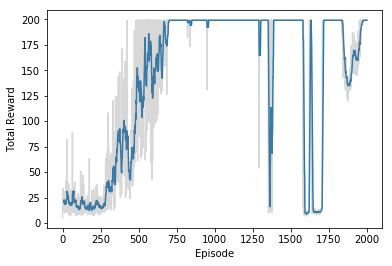

In [28]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.